In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [28]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *
from pytorch_inferno.inferno import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn.functional as F
from torch import optim, autograd, nn, Tensor
import torch
from torch.distributions import Normal

[autoreload of pytorch_inferno.data failed: Traceback (most recent call last):
  File "/Users/giles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/giles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 384, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/giles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 323, in update_generic
    update(a, b)
  File "/Users/giles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 288, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/giles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 323, in update_generic
    update(a, b)
  File "/Users/giles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 288, in update_class
    if update_generic(old_obj, new_obj)

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [ ]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=True, float_l=True),LossTracker(),SaveBest('weights/best_ie2.h5'),EarlyStopping(10)])

In [43]:
model.save('weights/Inferno_Test_exact_bm2.h5')

In [7]:
model.load('weights/Inferno_Test_exact_bm2.h5')

# Results

## BM 0

In [8]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [9]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,5,1.0
1,0,1.0
2,6,1.0
3,5,1.0
4,7,1.0


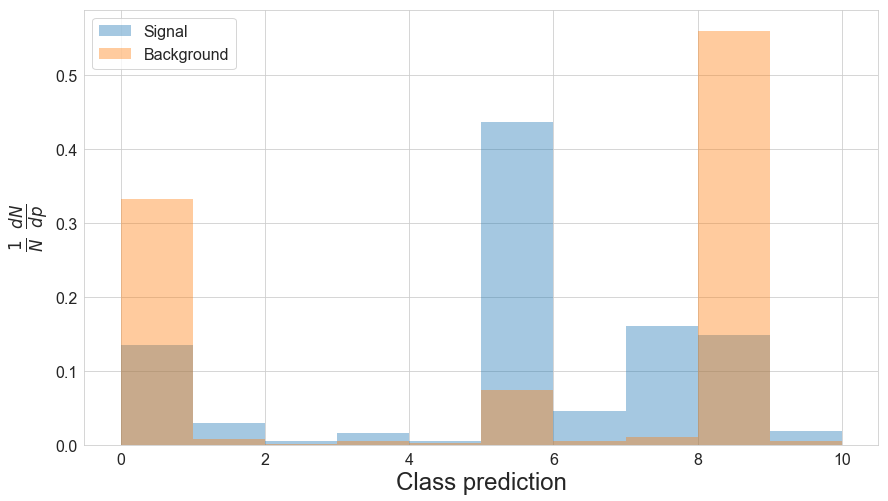

In [10]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [11]:
bin_preds(df)

In [12]:
df.head()

,pred,gen_target,pred_bin
0,5,1.0,5
1,0,1.0,0
2,6,1.0,6
3,5,1.0,5
4,7,1.0,7


In [13]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [14]:
f_s.sum(), f_b.sum()

(tensor(1.0000), tensor(1.0000))

In [15]:
f_s, f_b

(tensor([0.1353, 0.0292, 0.0057, 0.0155, 0.0052, 0.4362, 0.0452, 0.1607, 0.1479,
         0.0191]),
 tensor([0.3320, 0.0078, 0.0009, 0.0047, 0.0020, 0.0735, 0.0048, 0.0099, 0.5600,
         0.0045]))

In [16]:
asimov = (50*f_s)+(1000*f_b)

In [17]:
asimov, asimov.sum()

(tensor([338.7147,   9.2246,   1.2014,   5.4455,   2.2611,  95.3484,   7.0169,
          17.9564, 567.3840,   5.4470]), tensor(1050.))

In [18]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([25.52918243, 25.38249207, 25.24167442, 25.10655212, 24.97773361,
       24.85438156, 24.73703194, 24.62547684, 24.51914978, 24.41841507,
       24.3228817 , 24.23285294, 24.14792252, 24.06852531, 23.99347305,
       23.92399979, 23.85946274, 23.79966736, 23.74441528, 23.69437599,
       23.64862633, 23.60758209, 23.57124138, 23.53964424, 23.5117569 ,
       23.48870087, 23.46979523, 23.45549011, 23.44496727, 23.43928528,
       23.43695068, 23.4390316 , 23.44493866, 23.45502663, 23.46912575,
       23.48672676, 23.5082016 , 23.53370285, 23.5630455 , 23.59557152,
       23.63210678, 23.67222977, 23.71604156, 23.76305199, 23.81397629,
       23.86803246, 23.92549896, 23.98678017, 24.05082512, 24.11833763,
       24.18932533, 24.26343727, 24.34062958, 24.42130661, 24.50497818,
       24.5918293 , 24.68167877, 24.77469635, 24.87043381, 24.96918106,
       25.07128525])

In [19]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [20]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

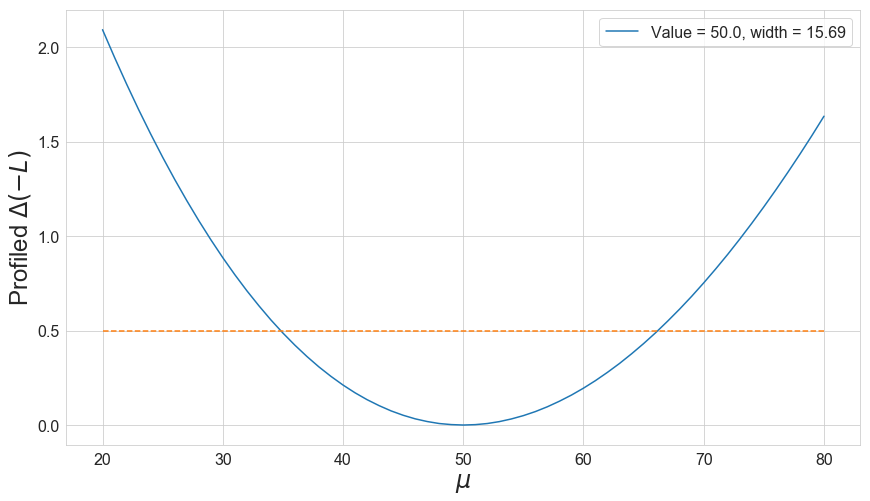

In [21]:
plot_likelihood(y-y.min())

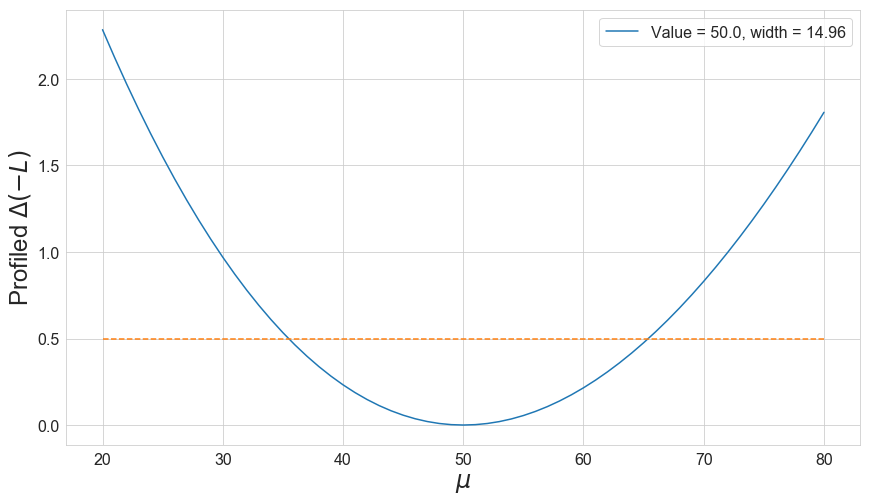

In [22]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [23]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [24]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [25]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,5,1.0,5,5,5,5,5,5,5,5,5,5,5
1,0,1.0,0,0,0,0,0,0,0,0,0,0,0
2,6,1.0,6,6,6,6,6,6,6,6,6,6,6
3,5,1.0,5,5,5,5,5,5,5,5,5,5,5
4,7,1.0,7,7,7,7,7,7,7,7,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.0,0,0,0,0,0,0,0,8,8,0,0
999996,8,0.0,8,8,8,8,8,8,8,8,8,8,8
999997,0,0.0,0,0,0,0,0,0,0,0,0,0,0
999998,0,0.0,0,0,0,0,0,0,0,0,0,0,0


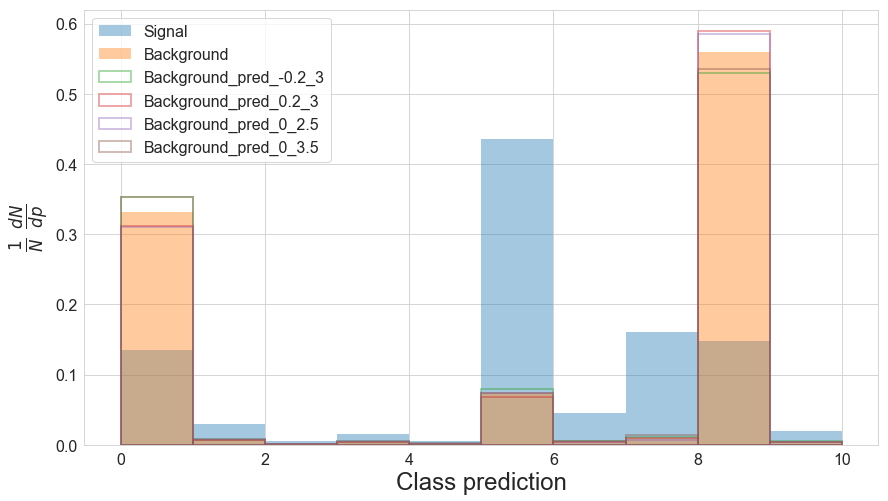

In [26]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([0.3311, 0.0096, 0.0006, 0.0055, 0.0023, 0.0791, 0.0044, 0.0077, 0.5551,
        0.0045])
tensor([0.3532, 0.0086, 0.0010, 0.0050, 0.0021, 0.0795, 0.0054, 0.0108, 0.5296,
        0.0048])
tensor([0.3742, 0.0078, 0.0014, 0.0046, 0.0018, 0.0797, 0.0064, 0.0142, 0.5050,
        0.0050])
tensor([3.0992e-01, 8.7540e-03, 5.7600e-04, 5.1560e-03, 2.2640e-03, 7.3126e-02,
        3.7440e-03, 6.8380e-03, 5.8546e-01, 4.1600e-03])
tensor([0.3320, 0.0078, 0.0009, 0.0047, 0.0020, 0.0735, 0.0048, 0.0099, 0.5600,
        0.0045])
tensor([0.3530, 0.0070, 0.0013, 0.0042, 0.0018, 0.0737, 0.0057, 0.0133, 0.5354,
        0.0047])
tensor([2.8908e-01, 8.0580e-03, 5.0200e-04, 4.5440e-03, 2.0720e-03, 6.7188e-02,
        3.3020e-03, 5.9280e-03, 6.1553e-01, 3.7980e-03])
tensor([0.3111, 0.0071, 0.0008, 0.0041, 0.0018, 0.0676, 0.0043, 0.0090, 0.5901,
        0.0041])
tensor([0.3322, 0.0063, 0.0012, 0.0036, 0.0016, 0.0677, 0.0053, 0.0124, 0.5654,
        0.0043])


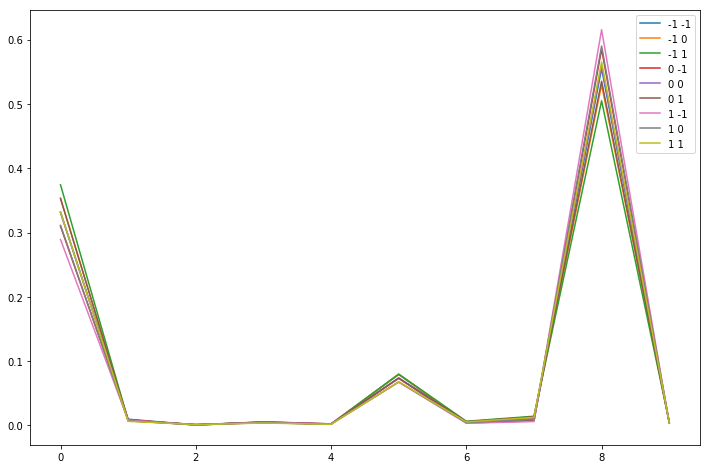

In [29]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [30]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [31]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [32]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [33]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [34]:
nll = to_np(nll)

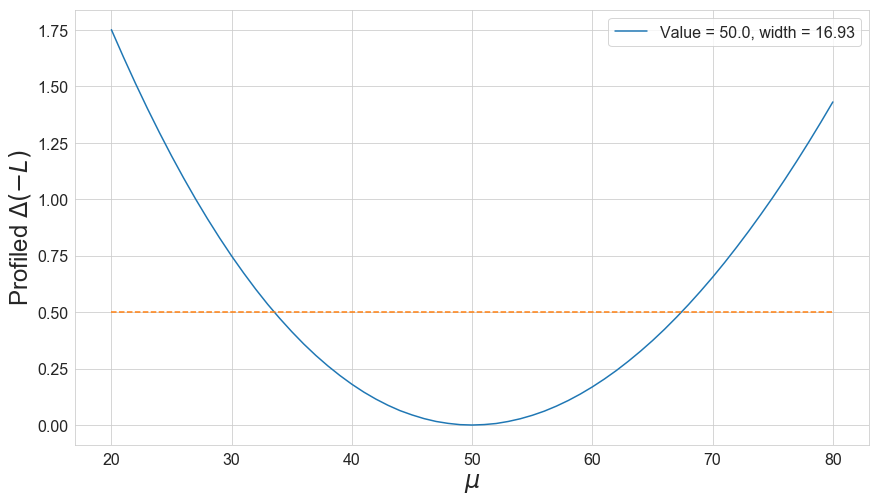

In [35]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [36]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [37]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [38]:
nll = to_np(nll)

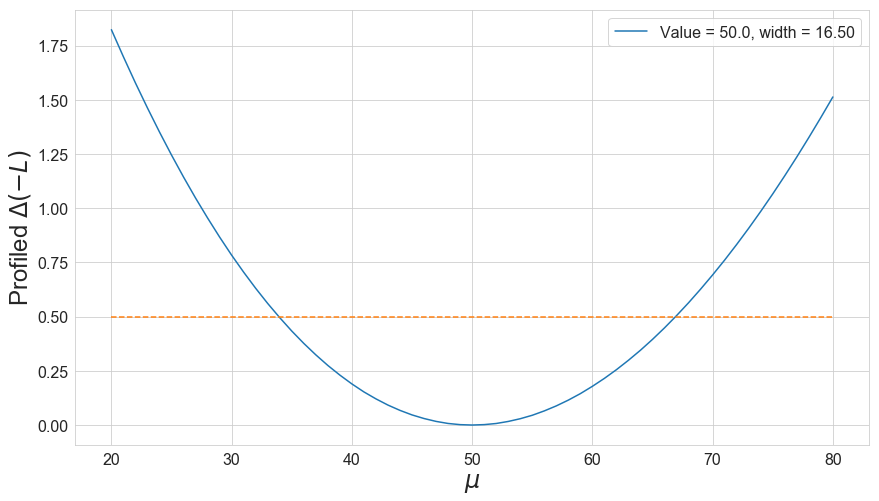

In [39]:
plot_likelihood(nll-nll.min())

## BM 2

In [40]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [41]:
nll = to_np(nll)

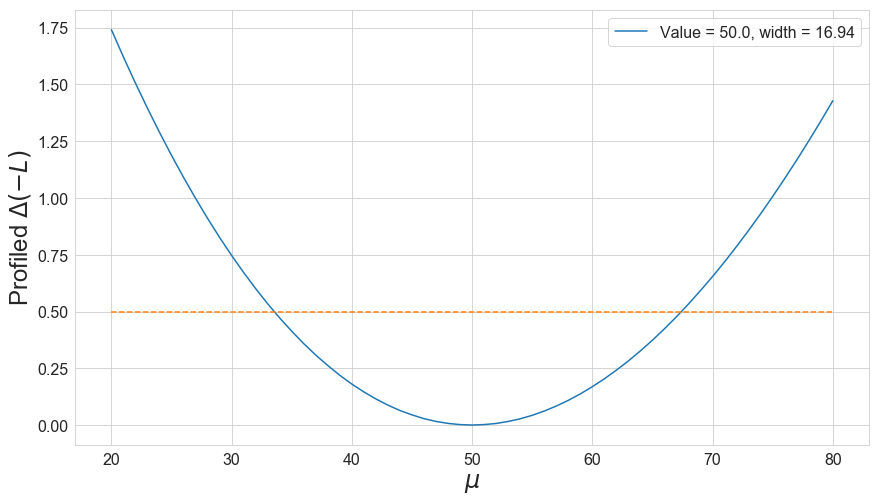

In [42]:
plot_likelihood(nll-nll.min())

## BM 3

In [43]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [44]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

In [45]:
nll = to_np(nll)

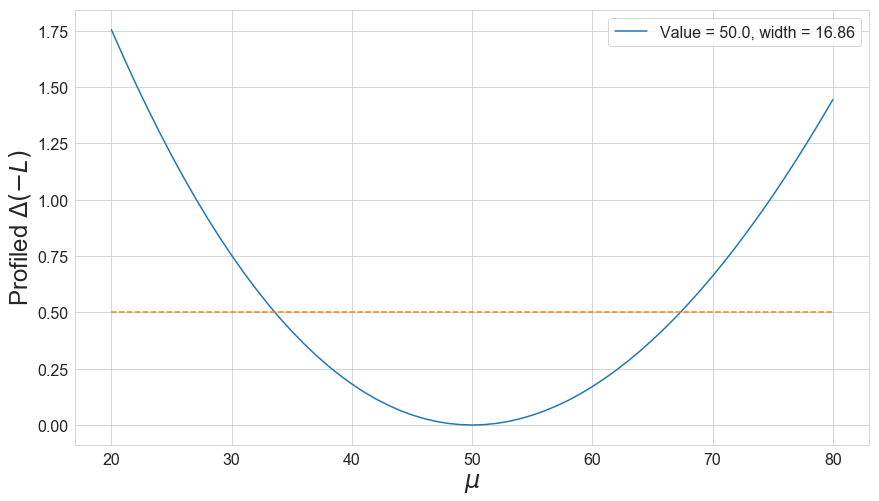

In [46]:
plot_likelihood(nll-nll.min())

## BM 4

In [47]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [48]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.3034,  0.1362, 25.4354])
Linear regime: Mu 21.0, alpha tensor([-0.2942,  0.1288, 24.5112])
Linear regime: Mu 22.0, alpha tensor([-0.2850,  0.1216, 23.5930])
Linear regime: Mu 23.0, alpha tensor([-0.2757,  0.1146, 22.6806])
Linear regime: Mu 24.0, alpha tensor([-0.2663,  0.1078, 21.7740])
Linear regime: Mu 25.0, alpha tensor([-0.2569,  0.1012, 20.8731])
Linear regime: Mu 26.0, alpha tensor([-0.2474,  0.0949, 19.9777])
Linear regime: Mu 27.0, alpha tensor([-0.2378,  0.0887, 19.0879])
Linear regime: Mu 28.0, alpha tensor([-0.2281,  0.0828, 18.2036])
Linear regime: Mu 29.0, alpha tensor([-0.2184,  0.0770, 17.3246])
Linear regime: Mu 30.0, alpha tensor([-0.2086,  0.0715, 16.4510])
Linear regime: Mu 31.0, alpha tensor([-0.1988,  0.0662, 15.5827])
Linear regime: Mu 32.0, alpha tensor([-0.1888,  0.0610, 14.7195])
Linear regime: Mu 33.0, alpha tensor([-0.1788,  0.0561, 13.8616])
Linear regime: Mu 34.0, alpha tensor([-0.1688,  0.0513, 13.0087])
Linear reg

In [49]:
nll = to_np(nll)

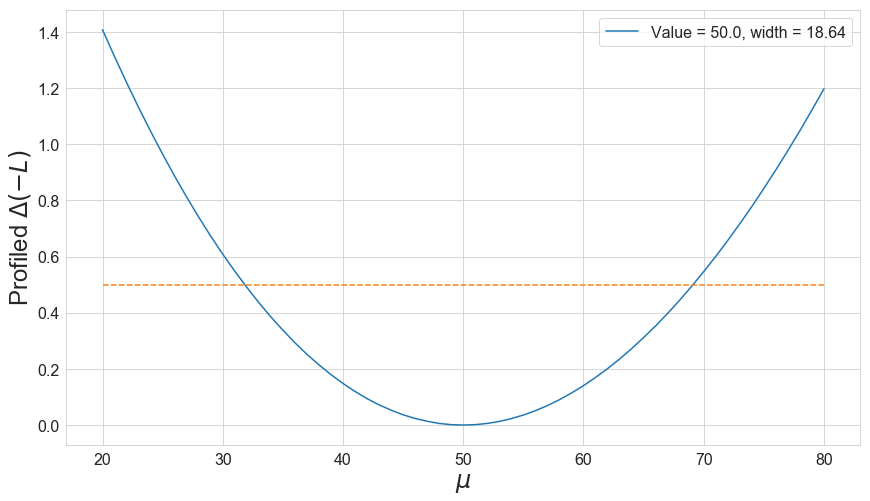

In [50]:
plot_likelihood(nll-nll.min())